# Flatland Javascript Renderer

This is in active development and is intended to replace the tkinter / PIL renderer.
This notebook shows how the JS renderer can be started in a notebook using an "iframe".  It starts a Flask server in a background thread, listening on port 8080, localhost.

In [1]:
import time
import os
import numpy as np 
from numpy import array
import threading
import webbrowser
import pandas as pd # useful for displaying tables
import ipysheet as ips
from IPython.display import HTML, display
from matplotlib import pyplot as plt
import PIL

In [2]:
%matplotlib inline

In [3]:
#pd.describe_option("rows")

In Flatland you can use custom observation builders and predicitors<br>
Observation builders generate the observation needed by the controller<br>
Preditctors can be used to do short time prediction which can help in avoiding conflicts in the network

In [4]:
from flatland.envs.malfunction_generators import malfunction_from_params, MalfunctionParameters
from flatland.envs.observations import GlobalObsForRailEnv
# First of all we import the Flatland rail environment
from flatland.envs.rail_env import RailEnv
from flatland.envs.rail_env import RailEnvActions
from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant
from flatland.utils.flask_util import simple_flask_server

Flask static folder:  /home/jeremy/projects/aicrowd/rl-trains/flatland/notebooks/static


This is an introduction example for the Flatland 2.1.* version.<br>
Changes and highlights of this version include<br>
- Stochastic events (malfunctions)<br>
- Different travel speeds for differet agents<br>
- Levels are generated using a novel generator to reflect more realistic railway networks<br>
- Agents start outside of the environment and enter at their own time<br>
- Agents leave the environment after they have reached their goal<br>
Use the new sparse_rail_generator to generate feasible network configurations with corresponding tasks<br>
Training on simple small tasks is the best way to get familiar with the environment<br>
We start by importing the necessary rail and schedule generators<br>
The rail generator will generate the railway infrastructure<br>
The schedule generator will assign tasks to all the agent within the railway network

The railway infrastructure can be build using any of the provided generators in env/rail_generators.py<br>
Here we use the sparse_rail_generator with the following parameters

In [5]:
nSize = 3

if nSize == 1: 
    width = 30  # With of map
    height = 30  # Height of map
    nr_trains = 5  # Number of trains that have an assigned task in the env
    cities_in_map = 2  # Number of cities where agents can start or end
elif nSize == 2:
    width = 8 * 7  # With of map
    height = 8 * 7  # Height of map
    nr_trains = 20  # Number of trains that have an assigned task in the env
    cities_in_map = 10  # Number of cities where agents can start or end
else:
    width = 16 * 7  # With of map
    height = 9 * 7  # Height of map
    nr_trains = 50  # Number of trains that have an assigned task in the env
    cities_in_map = 20  # Number of cities where agents can start or end
    
seed = 14  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation

In [6]:
generator_configs = [
    [30, 30, 5, 2],
    [8*7, 8*7, 20, 10],
    [16*7, 9*7, 50, 20],
]
dfConfig = pd.DataFrame(generator_configs, columns="width height nr_trains cities_in_map".split(" "))
dfConfig.index.name="config"
sheet = ips.from_dataframe(dfConfig.T)
sheet.column_resizing = True
sheet.column_width = [ 30, 30, 30 ]
sheet.stretch_headers = "none"
#sheet.rowHeaderWidth=200  # doesn't work

display(HTML("Here are the configuration options in an editable mini spreadsheet:"))
display(sheet)

Sheet(cells=(Cell(choice=[], column_end=0, column_start=0, numeric_format='0[.]0', row_start=0, squeeze_row=Fa…

In [7]:
n_config_column = 2
srConf = dfConfig.iloc[n_config_column,:]
srConf.width, srConf.height

(112, 63)

In [8]:
dfConf = ips.to_dataframe(sheet)
srConf = dfConf.iloc[:,n_config_column]
srConf

width            112
height            63
nr_trains         50
cities_in_map     20
Name: 2, dtype: int64

In [9]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rails_in_city=max_rail_in_cities,
                                       )

The schedule generator can make very basic schedules with a start point, end point and a speed profile for each agent.<br>
The speed profiles can be adjusted directly as well as shown later on. We start by introducing a statistical<br>
distribution of speed profiles

Different agent types (trains) with different speeds.

In [10]:
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

We can now initiate the schedule generator with the given speed profiles

In [11]:
schedule_generator = sparse_schedule_generator(speed_ration_map)

We can furthermore pass stochastic data to the RailEnv constructor which will allow for stochastic malfunctions<br>
during an episode.

In [12]:
stochastic_data = MalfunctionParameters(malfunction_rate=10000,  # Rate of malfunction occurence
                                        min_duration=15,  # Minimal duration of malfunction
                                        max_duration=50  # Max duration of malfunction
                                        )
# Custom observation builder without predictor
observation_builder = GlobalObsForRailEnv()

Custom observation builder with predictor, uncomment line below if you want to try this one<br>
observation_builder = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())

Construct the enviornment with the given observation, generataors, predictors, and stochastic data

In [13]:
env = RailEnv(width=srConf.width,
              height=srConf.height,
              rail_generator=rail_generator,
              schedule_generator=schedule_generator,
              number_of_agents=srConf.nr_trains,
              obs_builder_object=observation_builder,
              malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              remove_agents_at_target=True)
env.reset()
pass

Initiate the renderer

In [14]:
env_renderer = RenderTool(env, # gl="PILSVG", # defaults to BROWSER
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False)
                          
render_pil = RenderTool(env, gl="PILSVG",
                          agent_render_variant=AgentRenderVariant.ONE_STEP_BEHIND,
                          show_debug=False,
                          screen_height=1000,  # Adjust these parameters to fit your resolution
                          screen_width=1300)  # Adjust these parameters to fit your resolution



WebSocket transport not available. Install eventlet or gevent and gevent-websocket for improved performance.


 * Serving Flask app "flatland.utils.flask_util" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8081/ (Press CTRL+C to quit)


The first thing we notice is that some agents don't have feasible paths to their target.<br>
We first look at the map we have created

nv_renderer.render_env(show=True)<br>
time.sleep(2)<br>
Import your own Agent or use RLlib to train agents on Flatland<br>
As an example we use a random agent instead

In [15]:
class RandomAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
    def act(self, state):
        """
        :param state: input is the observation of the agent
        :return: returns an action
        """
        return np.random.choice([RailEnvActions.MOVE_FORWARD, RailEnvActions.MOVE_RIGHT, RailEnvActions.MOVE_LEFT,
                                 RailEnvActions.STOP_MOVING])
    def step(self, memories):
        """
        Step function to improve agent by adjusting policy given the observations
        :param memories: SARS Tuple to be
        :return:
        """
        return
    def save(self, filename):
        # Store the current policy
        return
    def load(self, filename):
        # Load a policy
        return

Initialize the agent with the parameters corresponding to the environment and observation_builder

In [16]:
controller = RandomAgent(218, env.action_space[0])

We start by looking at the information of each agent<br>
We can see the task assigned to the agent by looking at

In [17]:

dfAgents = pd.DataFrame(
    [ (agent_idx, agent.initial_position, agent.direction, agent.target)
     for agent_idx, agent in enumerate(env.agents) 
    ],
    columns="idx,initial_pos,direction,target".split(",")
)
  

display(HTML("<h2>Agents in the environment have to solve the following tasks:</h2>"))
pd.set_option("display.max_rows", 10)
display(dfAgents)

,idx,initial_pos,direction,target
0,0,"(22, 74)",2,"(19, 93)"
1,1,"(7, 12)",0,"(44, 16)"
2,2,"(19, 92)",2,"(21, 9)"
3,3,"(42, 71)",3,"(18, 52)"
4,4,"(39, 16)",3,"(19, 95)"
...,...,...,...,...
45,45,"(37, 57)",1,"(45, 102)"
46,46,"(43, 16)",1,"(6, 94)"
47,47,"(56, 26)",0,"(18, 52)"
48,48,"(41, 16)",3,"(32, 89)"


The agent will always have a status indicating if it is currently present in the environment or done or active<br>
For example we see that agent with index 0 is currently not active

In [18]:
print("\n Their current statuses are:")
print("============================")


 Their current statuses are:


In [19]:
dfAgStatus = pd.DataFrame(
    [
        (str(agent.status), str(agent.position))
        for agent_idx, agent in enumerate(env.agents)
    ], columns=["Status", "CurPosn"])
display(dfAgStatus)
# print("Agent {} status is: {} with its current position being {}".format(agent_idx, str(agent.status),
#str(agent.position)))

,Status,CurPosn
0,RailAgentStatus.READY_TO_DEPART,None
1,RailAgentStatus.READY_TO_DEPART,None
2,RailAgentStatus.READY_TO_DEPART,None
3,RailAgentStatus.READY_TO_DEPART,None
4,RailAgentStatus.READY_TO_DEPART,None
...,...,...
45,RailAgentStatus.READY_TO_DEPART,None
46,RailAgentStatus.READY_TO_DEPART,None
47,RailAgentStatus.READY_TO_DEPART,None
48,RailAgentStatus.READY_TO_DEPART,None


The agent needs to take any action [1,2,3] except do_nothing or stop to enter the level<br>
If the starting cell is free they will enter the level<br>
If multiple agents want to enter the same cell at the same time the lower index agent will enter first.

Let's check if there are any agents with the same start location

In [20]:
agents_with_same_start = set()
agent_pairs = []
dict_pos_agents = {}

for iAgent, agent in enumerate(env.agents):
    rcPos = agent.initial_position
    if rcPos in dict_pos_agents:
        dict_pos_agents[rcPos].append(iAgent)
    else:
        dict_pos_agents[rcPos] = [iAgent]
pd.set_option("display.max_rows", 30)
df_init = pd.DataFrame(dict_pos_agents.items(), columns=["Initial_Posn", "Agent_indices"])
df_init["nAgents"] = df_init.Agent_indices.apply(len)
agents_with_same_start = sorted(np.sum(df_init.Agent_indices[df_init.nAgents>1].values))
df_init[df_init.nAgents > 1]

,Initial_Posn,Agent_indices,nAgents
0,"(22, 74)","[0, 34]",2
2,"(19, 92)","[2, 24]",2
4,"(39, 16)","[4, 14, 37]",3
6,"(6, 93)","[6, 41]",2
7,"(41, 29)","[7, 40, 49]",3
8,"(50, 44)","[8, 25, 44]",3
10,"(41, 16)","[10, 28, 38, 48]",4
11,"(19, 96)","[11, 18]",2
12,"(32, 86)","[12, 17, 27]",3
13,"(53, 63)","[13, 29]",2


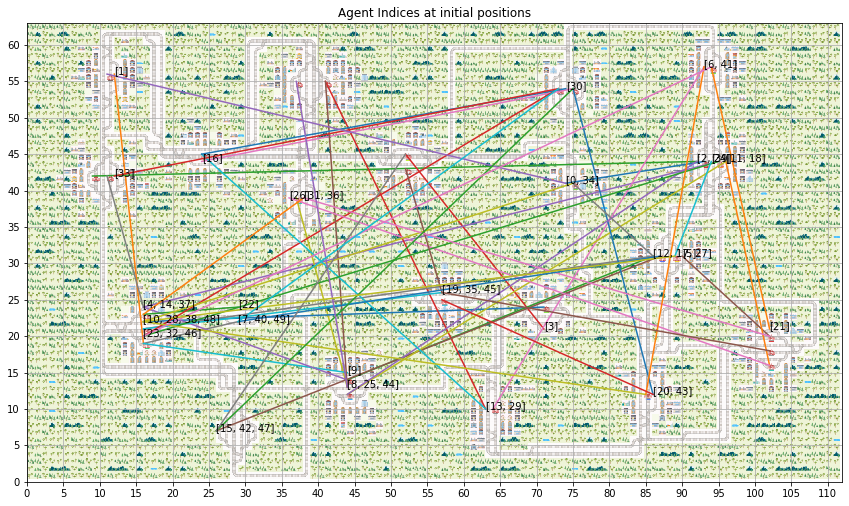

In [21]:
r_aspect = srConf.width / srConf.height
chart_width_inches = 15
plt.figure(figsize=(chart_width_inches, chart_width_inches / r_aspect))

rc2xy = array([[0,1],[-1,0]]).T # matrix to convert row, col -> x, y - height
for agent in env.agents:
    rc1 = array(agent.initial_position)
    rc2 = array(agent.target)
    rc12 = np.stack([rc1, rc2])
    xy12 = np.matmul(rc12, rc2xy)
    plt.plot(xy12[:,0], srConf.height + xy12[:,1])

for rcStart, liAgent in dict_pos_agents.items():
    xyStart = np.matmul(array(rcStart), rc2xy) + [0,srConf.height]
    plt.annotate(liAgent, xyStart)
    
#plt.xlim(0,srConf.width)
#plt.ylim(0,srConf.height)
plt.xticks(range(0,srConf.width, 5))
plt.yticks(range(0,srConf.height, 5))
plt.grid()
plt.title("Agent Indices at initial positions")
render_pil.render_env(show=False, show_observations=False)
plt.imshow(render_pil.get_image(), extent = [0,srConf.width,0,srConf.height])

Lets try to enter with all of these agents at the same time

In [22]:
action_dict = dict()

In [23]:
for agent_id in agents_with_same_start:
    action_dict[agent_id] = 1  # Try to move with the agents

Do a step in the environment to see what agents entered:

In [24]:
env.step(action_dict)
pass

### Current state and position of the agents after all agents with same start position tried to move

In [25]:
dfStatus = pd.DataFrame([
    (agent_id, str(agent.status), str(agent.initial_position), str(agent.position) )
    for agent_id, agent in [ (agent_id, env.agents[agent_id]) for agent_id in agents_with_same_start]
], columns=["agent_id", "status", "initial_pos", "position"])
# pd.options.display.max_rows = 10  # for some reason, doesn't work here
dfStatus.sort_values(["initial_pos", "agent_id"]).iloc[pd.np.r_[0:10, -10:0]].style.hide_index()

agent_id,status,initial_pos,position
2,RailAgentStatus.ACTIVE,"(19, 92)","(19, 92)"
24,RailAgentStatus.READY_TO_DEPART,"(19, 92)",None
11,RailAgentStatus.ACTIVE,"(19, 96)","(19, 96)"
18,RailAgentStatus.READY_TO_DEPART,"(19, 96)",None
0,RailAgentStatus.ACTIVE,"(22, 74)","(22, 74)"
34,RailAgentStatus.READY_TO_DEPART,"(22, 74)",None
31,RailAgentStatus.ACTIVE,"(24, 38)","(24, 38)"
36,RailAgentStatus.READY_TO_DEPART,"(24, 38)",None
12,RailAgentStatus.ACTIVE,"(32, 86)","(32, 86)"
17,RailAgentStatus.READY_TO_DEPART,"(32, 86)",None


As you see only the agents with lower indexes moved. As soon as the cell is free again the agents can attempt<br>
to start again.

You will also notice, that the agents move at different speeds once they are on the rail.<br>
The agents will always move at full speed when moving, never a speed inbetween.<br>
The fastest an agent can go is 1, meaning that it moves to the next cell at every time step<br>
All slower speeds indicate the fraction of a cell that is moved at each time step<br>
Lets look at the current speed data of the agents:

In [26]:
print("\n The speed information of the agents are:")
print("=========================================")


 The speed information of the agents are:


In [27]:
pd.DataFrame([
    (agent_id, agent.speed_data["speed"], agent.speed_data["position_fraction"])
    for agent_id, agent in enumerate(env.agents)
], columns = ["agent_id", "speed", "position_fraction"])
#for agent_idx, agent in enumerate(env.agents):
#    print(
#        "Agent {} speed is: {:.2f} with the current fractional position being {}".format(
#            agent_idx, agent.speed_data['speed'], agent.speed_data['position_fraction']))

,agent_id,speed,position_fraction
0,0,0.250000,0.0
1,1,0.333333,0.0
2,2,0.250000,0.0
3,3,0.250000,0.0
4,4,1.000000,0.0
5,5,0.500000,0.0
6,6,0.250000,0.0
7,7,0.250000,0.0
8,8,0.250000,0.0
9,9,0.500000,0.0


Now the agents can also have stochastic malfunctions happening which will lead to them being unable to move<br>
for a certain amount of time steps. The malfunction data of the agents can easily be accessed as follows

In [28]:
print("\n The malfunction data of the agents are:")
print("========================================")


 The malfunction data of the agents are:


In [29]:
#for agent_idx, agent in enumerate(env.agents):
#    print(
#        "Agent {} is OK = {}".format(
#            agent_idx, agent.malfunction_data['malfunction'] < 1))
pd.DataFrame([ (agent_id, agent.malfunction_data["malfunction"])
              for agent_id, agent in enumerate(env.agents)
             ], columns=["agent_id", "malfunction"])

,agent_id,malfunction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


Now that you have seen these novel concepts that were introduced you will realize that agents don't need to take<br>
an action at every time step as it will only change the outcome when actions are chosen at cell entry.<br>
Therefore the environment provides information about what agents need to provide an action in the next step.<br>
You can access this in the following way.

Chose an action for each agent

In [30]:
for a in range(env.get_num_agents()):
    action = controller.act(0)
    action_dict.update({a: action})
# Do the environment step
observations, rewards, dones, information = env.step(action_dict)
print("\n The following agents can register an action:")
print("========================================")
for info in information['action_required']:
    print("Agent {} needs to submit an action.".format(info))


 The following agents can register an action:
Agent 0 needs to submit an action.
Agent 1 needs to submit an action.
Agent 2 needs to submit an action.
Agent 3 needs to submit an action.
Agent 4 needs to submit an action.
Agent 5 needs to submit an action.
Agent 6 needs to submit an action.
Agent 7 needs to submit an action.
Agent 8 needs to submit an action.
Agent 9 needs to submit an action.
Agent 10 needs to submit an action.
Agent 11 needs to submit an action.
Agent 12 needs to submit an action.
Agent 13 needs to submit an action.
Agent 14 needs to submit an action.
Agent 15 needs to submit an action.
Agent 16 needs to submit an action.
Agent 17 needs to submit an action.
Agent 18 needs to submit an action.
Agent 19 needs to submit an action.
Agent 20 needs to submit an action.
Agent 21 needs to submit an action.
Agent 22 needs to submit an action.
Agent 23 needs to submit an action.
Agent 24 needs to submit an action.
Agent 25 needs to submit an action.
Agent 26 needs to submit an

In [31]:
dfPos = pd.DataFrame([
    (agent_id, agent.speed_data["speed"], agent.speed_data["position_fraction"], str(agent.status))
    for agent_id, agent in enumerate(env.agents)
], columns = ["agent_id", "speed", "position_fraction", "status"])
dfPos["action_required"] = pd.Series(information["action_required"])
pd.options.display.max_rows=20
dfPos

,agent_id,speed,position_fraction,status,action_required
0,0,0.250000,0.25,RailAgentStatus.ACTIVE,False
1,1,0.333333,0.00,RailAgentStatus.READY_TO_DEPART,True
2,2,0.250000,0.25,RailAgentStatus.ACTIVE,False
3,3,0.250000,0.00,RailAgentStatus.ACTIVE,True
4,4,1.000000,0.00,RailAgentStatus.ACTIVE,True
5,5,0.500000,0.00,RailAgentStatus.ACTIVE,True
6,6,0.250000,0.25,RailAgentStatus.ACTIVE,False
7,7,0.250000,0.25,RailAgentStatus.ACTIVE,False
8,8,0.250000,0.25,RailAgentStatus.ACTIVE,False
9,9,0.500000,0.00,RailAgentStatus.ACTIVE,True


We recommend that you monitor the malfunction data and the action required in order to optimize your training<br>
and controlling code.

Let us now look at an episode playing out with random actions performed

In [32]:
print("\nStart episode...")


Start episode...


Reset the rendering system

In [33]:
env_renderer.reset()

Here you can also further enhance the provided observation by means of normalization<br>
See training navigation example in the baseline repository

## Javascript Renderer
The cell below should create an HTML "iframe" which is like a new window within a window.
It loads from the Flask server created above, and which should now be running in the background, listening on localhost:8080.  The server should have been created with the Flatland RailEnv.  When the JS Renderer connects to the server, it should load the env data, ie the rails and agent positions.

Note that only one server can be running on the host / machine / VM because it is configured to listen on a fixed port (8080).  Only one JS renderer can connect to the server. 

If you start more than one, only one will work, and it may be glitchy.  However it can be convenient to start a new window pointing to the server on http://localhost:8080/index.html - you can then position the viewer elsewhere, and run steps from the cells below.

In [34]:
url = env_renderer.get_endpoint_URL()
HTML("<a href={}> Click here to open viewer at {}</a>".format(url, url))

In [35]:
#%%html
#<iframe src="http://127.0.0.1:8080/index.html" height=500 width=600 />

In [36]:
score = 0
# Run episode
frame_step = 0

In [37]:
nSteps = 3

127.0.0.1 - - [02/Jan/2020 17:55:25] "GET /socket.io/?EIO=3&transport=polling&t=MzdPSrt&sid=4b92b171470243629651954a72f7b4cb HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 17:55:25] "GET /socket.io/?EIO=3&transport=polling&t=MzdPTTg&sid=4b92b171470243629651954a72f7b4cb HTTP/1.1" 200 -
127.0.0.1 - - [02/Jan/2020 17:55:25] "GET /socket.io/?EIO=3&transport=polling&t=MzdPTUw&sid=4b92b171470243629651954a72f7b4cb HTTP/1.1" 200 -


Episode: Steps 16	 Score = -414.66666666666555
Episode: Steps 17	 Score = -440.58333333333195
Episode: Steps 18	 Score = -466.49999999999835


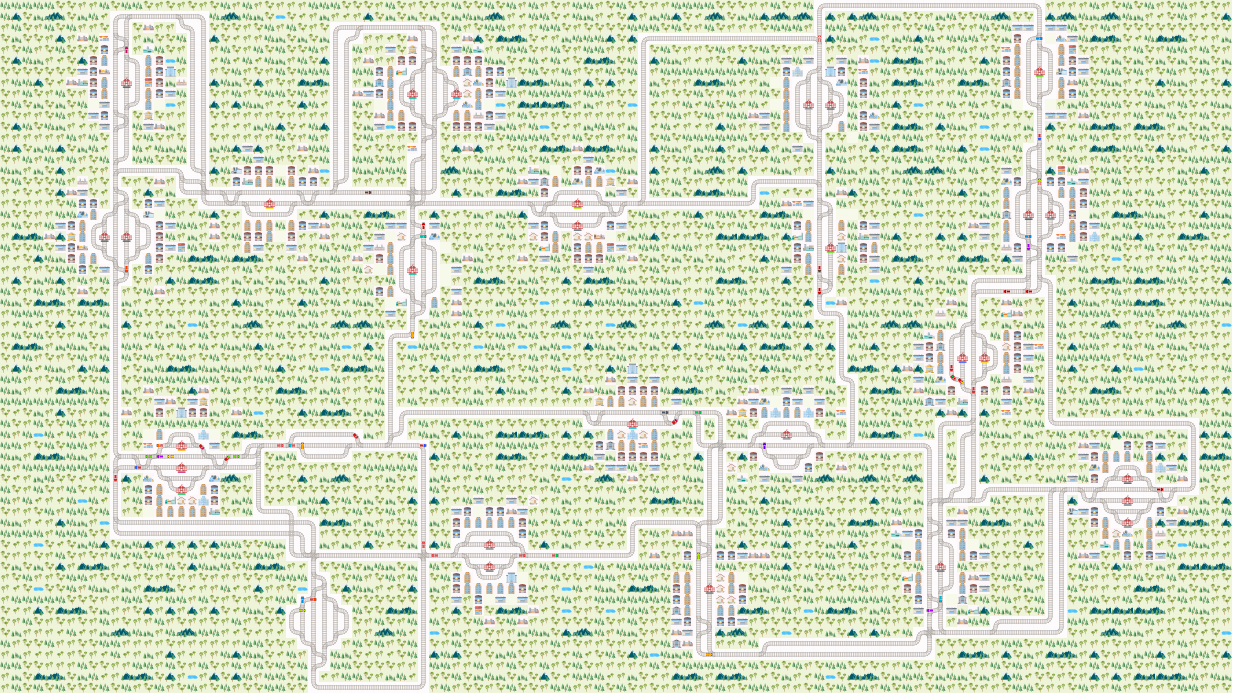

In [43]:
for step in range(nSteps):
    # Chose an action for each agent in the environment
    for a in range(env.get_num_agents()):
        action = controller.act(observations[a])
        action_dict.update({a: action})

    # Environment step which returns the observations for all agents, their corresponding
    # reward and whether their are done
    next_obs, all_rewards, done, _ = env.step(action_dict)
    
    env_renderer.render_env(show=False, show_observations=False, show_predictions=False)
    
    # env_renderer.gl.save_image('./misc/Fames2/flatland_frame_{:04d}.png'.format(step))
    frame_step += 1
    # Update replay buffer and train agent
    for a in range(env.get_num_agents()):
        controller.step((observations[a], action_dict[a], all_rewards[a], next_obs[a], done[a]))
        score += all_rewards[a]
    observations = next_obs.copy()
    if done['__all__']:
        print("All done!")
        break
    print('Episode: Steps {}\t Score = {}'.format(frame_step, score))
    
    time.sleep(0.01)

render_pil.render_env(show=False, show_observations=False, show_predictions=False, show_agents=True)
display(PIL.Image.fromarray(render_pil.get_image()))


<app-root></app-root>
<script>
try{
    window.nodeRequire = require;
    delete window.require;
    delete window.exports;
    delete window.module;
} catch (e) {}
</script>

<script src="static/runtime.js" defer></script>
<script src="static/polyfills-es5.js" nomodule defer></script>
<script src="static/polyfills.js" defer></script>
<script src="static/styles.js" defer></script>
<script src="static/scripts.js" defer></script>
<script src="static/vendor.js" defer></script>
<script src="static/main.js" defer></script>
</body>